In [1]:
#loading packages
import pandas as pd
import numpy as np
import csv
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_validate
%matplotlib inline

from pprint import pprint
from rdkit import Chem
from mordred import Calculator, descriptors
from rdkit.Chem import AllChem
from rdkit.Chem.EState import Fingerprinter
from rdkit.Chem import Descriptors
from rdkit.Chem.rdmolops import RDKFingerprint

In [17]:
#loading data
directory = 'D:/jupyter_workspace/wmj'
# paperdat = pd.read_csv("2014acdata.csv"),  ##remove EC50 value larger than 500 in wmj_smiles2
filename = 'wmj_smiles2.csv'
data = pd.read_csv(os.path.join(directory,filename))

#define labels and the variables
###good smiles check ahead of every mds calculation,check the smiles is good canonical smiles 
smi = data['smiles']
goodsmi =[]
for a in smi:
    try:
        b = Chem.CanonSmiles(a)
        goodsmi.append(b)
    except:
        print('Invalid SMILES:',b)
# goodsmi
print('no bad smiles\n')

data['Mol'] = data['smiles'].apply(Chem.MolFromSmiles)
num_mols = len(data)
print(num_mols)

no bad smiles

34


In [5]:
# #define labels and the variables
# ###good smiles check ahead of every mds calculation,check the smiles is good canonical smiles 
# smi = data['smiles']
# goodsmi =[]
# for a in smi:
#     try:
#         b = Chem.CanonSmiles(a)
#         goodsmi.append(b)
#     except:
#         print('Invalid SMILES:',b)
# # goodsmi
# print('no bad smiles\n')

# data['Mol'] = data['smiles'].apply(Chem.MolFromSmiles)
# num_mols = len(data)
# print(len(data))

no bad smiles

34


In [18]:
#Create X and y
#Convert to Numpy arrays
y = data['category'].values

In [19]:
from rdkit.Chem.AtomPairs.Sheridan import GetBPFingerprint
from rdkit.Chem.EState.Fingerprinter import FingerprintMol
from rdkit.Avalon.pyAvalonTools import GetAvalonFP #GetAvalonCountFP  #int vector version
from rdkit.Chem.AllChem import  GetMorganFingerprintAsBitVect, GetErGFingerprint,GetHashedAtomPairFingerprintAsBitVect,GetHashedTopologicalTorsionFingerprintAsBitVect
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
import rdkit.DataStructs.cDataStructs

def ExplicitBitVect_to_NumpyArray(bitvector):
    bitstring = bitvector.ToBitString()
    intmap = map(int, bitstring)
    return np.array(list(intmap))


class fingerprint():
    def __init__(self, fp_fun, name):
        self.fp_fun = fp_fun
        self.name = name
        self.x = []

    def apply_fp(self, mols):
        for mol in mols:
            fp = self.fp_fun(mol)
            if isinstance(fp, tuple):
                fp = np.array(list(fp[0]))
            if isinstance(fp, rdkit.DataStructs.cDataStructs.ExplicitBitVect):
                fp = ExplicitBitVect_to_NumpyArray(fp)
            if isinstance(fp,rdkit.DataStructs.cDataStructs.IntSparseIntVect):
                fp = np.array(list(fp))

            self.x += [fp]

            if (str(type(self.x[0])) != "<class 'numpy.ndarray'>"):
                print("WARNING: type for ", self.name, "is ", type(self.x[0]))

def make_fingerprints(length = 512, verbose=False):
    fp_list = [
         #fingerprint(lambda x : GetBPFingerprint(x, fpfn=AtomPair), 
         #            "Physiochemical properties (1996)"), ##NOTE: takes a long time to compute
         fingerprint(lambda x : GetHashedAtomPairFingerprintAsBitVect(x, nBits = length),
                    " Atom pair (1985)"),
         fingerprint(lambda x : GetHashedTopologicalTorsionFingerprintAsBitVect(x, nBits = length),
                     "Topological torsion (1987)"),
         fingerprint(lambda x : GetMorganFingerprintAsBitVect(x, 2, nBits = length),
                     "Morgan circular "),
         fingerprint(FingerprintMol, "Estate (1995)"),
         fingerprint(lambda x: GetAvalonFP(x, nBits=length),
                    "Avalon bit based (2006)"),
         fingerprint(lambda x: np.append(GetAvalonFP(x, nBits=length), Descriptors.MolWt(x)),
                    "Avalon+mol. weight"),
         fingerprint(lambda x: GetErGFingerprint(x), "ErG fingerprint (2006)"),
         fingerprint(lambda x : RDKFingerprint(x, fpSize=length),
                     "RDKit fingerprint")
    ]

    for fp in fp_list:
        if (verbose): print("doing", fp.name)
        fp.apply_fp(list(data['Mol']))

    return fp_list

fp_list = make_fingerprints()

In [20]:
from sklearn.model_selection import cross_val_score
def test_model_cv(model, x, y, cv=10):
    scores = cross_val_score(model, x, y, cv=cv, n_jobs=-1, 
scoring='accuracy')

    return scores.mean()

def test_fingerprints(fp_list, model, y, verbose = True):

    fingerprint_scores = {}

    for fp in fp_list:
        if verbose: print("doing ", fp.name)
        fingerprint_scores[fp.name] = test_model_cv(model, fp.x, y)

    sorted_names = sorted(fingerprint_scores, key=fingerprint_scores.__getitem__, reverse=False)

    print("\\begin{tabular}{c c}")
    print("           name        &  avg accuracy in CV \\\\")
    print("\\hline")
    for i in range(len(sorted_names)):
        name = sorted_names[i]
        print("%30s & %5.3f \\\\" % (name, fingerprint_scores[name]))
    print("\\end{tabular}")

    
model=RandomForestClassifier(n_estimators=200, max_depth=3,
                          random_state=0)
test_fingerprints(fp_list,model, y, verbose=True)

doing   Atom pair (1985)


E:\anaconda\envs\MRMdatabase\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


doing  Topological torsion (1987)


E:\anaconda\envs\MRMdatabase\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


doing  Morgan circular 


E:\anaconda\envs\MRMdatabase\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


doing  Estate (1995)


E:\anaconda\envs\MRMdatabase\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


doing  Avalon bit based (2006)


E:\anaconda\envs\MRMdatabase\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


doing  Avalon+mol. weight


E:\anaconda\envs\MRMdatabase\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


doing  ErG fingerprint (2006)


E:\anaconda\envs\MRMdatabase\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


doing  RDKit fingerprint


E:\anaconda\envs\MRMdatabase\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


\begin{tabular}{c c}
           name        &  avg accuracy in CV \\
\hline
              Atom pair (1985) & 0.667 \\
       Avalon bit based (2006) & 0.667 \\
            Avalon+mol. weight & 0.667 \\
              Morgan circular  & 0.692 \\
             RDKit fingerprint & 0.692 \\
                 Estate (1995) & 0.717 \\
        ErG fingerprint (2006) & 0.717 \\
    Topological torsion (1987) & 0.742 \\
\end{tabular}


In [21]:
features = fp_list[1].x
labels = np.array(y)

In [ ]:
# import numpy as np
# from rdkit import Chem
# from rdkit.Chem import AllChem
# from rdkit.Chem import DataStructs
# mol = Chem.MolFromSmiles('C1CCCOC1')
# fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=512)
# arr = np.zeros((0,), dtype=np.int8)
# arr
# DataStructs.ConvertToNumpyArray(fp,arr)
# arr

In [ ]:
# from rdkit.Chem import DataStructs
# fparr=[]
# for fp in fplst:
#     arr = np.zeros((0,), dtype=int)
#     DataStructs.ConvertToNumpyArray(fp,arr)
#     print(arr)
#     fparr.append(arr)

In [22]:
#clear dataset and split the data
# dataset = {'ID':mydat['ID'], 'MFP':fparr, 'category':mydat['category']}
# dataset = pd.DataFrame(dataset, columns = ['ID','MFP','category'])
# dataset = dataset.set_index('ID')
# features = dataset['MFP']
# labels = dataset['category']
X_train, X_test, y_train, y_test ,indices_train, indices_test= train_test_split(features, labels, data.index,test_size=0.3, 
                                                                                 random_state=1)

# baseline model with rf，NB classifier

E:\anaconda\envs\MRMdatabase\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
E:\anaconda\envs\MRMdatabase\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
E:\anaconda\envs\MRMdatabase\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
E:\anaconda\envs\MRMdatabase\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


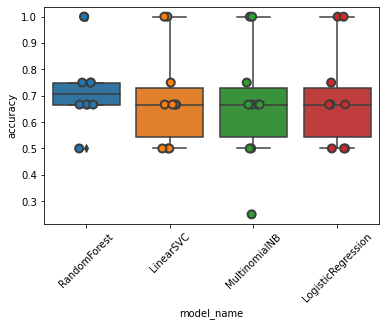

In [39]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

models=[
    RandomForestClassifier(n_estimators=200, max_depth=3,
                          random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV=10
cv_df = pd.DataFrame(index=range(CV*len(models)))
entris=[]
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels,
                                scoring = 'accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entris.append((model_name,fold_idx, accuracy))
cv_df = pd.DataFrame(entris,columns=['model_name','fold_idx',
                                         'accuracy'])
x_label=['RandomForest','LinearSVC','MultinomialNB','LogisticRegression']
import seaborn as sns
fg=sns.boxplot(x='model_name', y='accuracy', data=cv_df)
fg=sns.stripplot(x='model_name', y = 'accuracy', data=cv_df,
             size=8, jitter=True, edgecolor='gray', linewidth=2)
# plt.show()
fg.set_xticklabels(x_label, rotation=45)
fg.figure.savefig('classifiercompare.png',bbox_inches='tight')

In [34]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.691667
LogisticRegression        0.691667
MultinomialNB             0.666667
RandomForestClassifier    0.741667
Name: accuracy, dtype: float64

In [40]:
#use LinearSVC for modeling
model = RandomForestClassifier()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, data.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [43]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Confusion Matrix

[[0 2 2]
 [0 4 1]
 [0 0 3]]


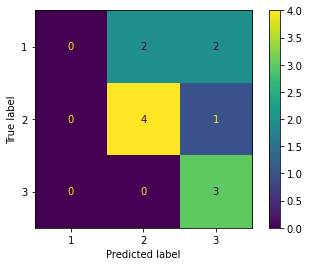

In [41]:
#importing confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)
plot_confusion_matrix(model,X_test,y_test)


In [37]:
from sklearn import metrics
print(metrics.classification_report(y_test,y_pred,
                target_names=['class1','class2','class3']))

              precision    recall  f1-score   support

      class1       1.00      0.25      0.40         4
      class2       0.67      0.80      0.73         5
      class3       0.60      1.00      0.75         3

    accuracy                           0.67        12
   macro avg       0.76      0.68      0.63        12
weighted avg       0.76      0.67      0.62        12

